In [1]:
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 41.5 MB/s eta 0:00:00


In [2]:
# blocks output in Colab 💄
%%capture

! pip install datasets transformers

In [3]:
! pip install -q kaggle

In [4]:
!pip install accelerate -U

## Load a dataset

In [5]:
from google.colab import files

In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nihalsrivastava","key":"0ee73569f29d3fcbf29a4e9e5bad989b"}'}

In [7]:
! mkdir ~/.kaggle

In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
! chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

 99% 1.51G/1.52G [00:21<00:00, 104MB/s] 
100% 1.52G/1.52G [00:21<00:00, 77.2MB/s]


In [11]:
!unzip ct-kidney-dataset-normal-cyst-tumor-and-stone.zip

Streaming output truncated to the last 5000 lines.
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4363).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4364).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4365).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4366).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4367).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4368).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (4369).jpg  
  inflating: CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-N

In [12]:
from datasets import load_dataset

In [13]:
dataset = load_dataset("imagefolder", data_dir="./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/", drop_labels=False)

Resolving data files:   0%|          | 0/12446 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [14]:
dataset = dataset.rename_column('label', 'labels')

In [15]:
ex = dataset['train'][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=798x646>,
 'labels': 0}

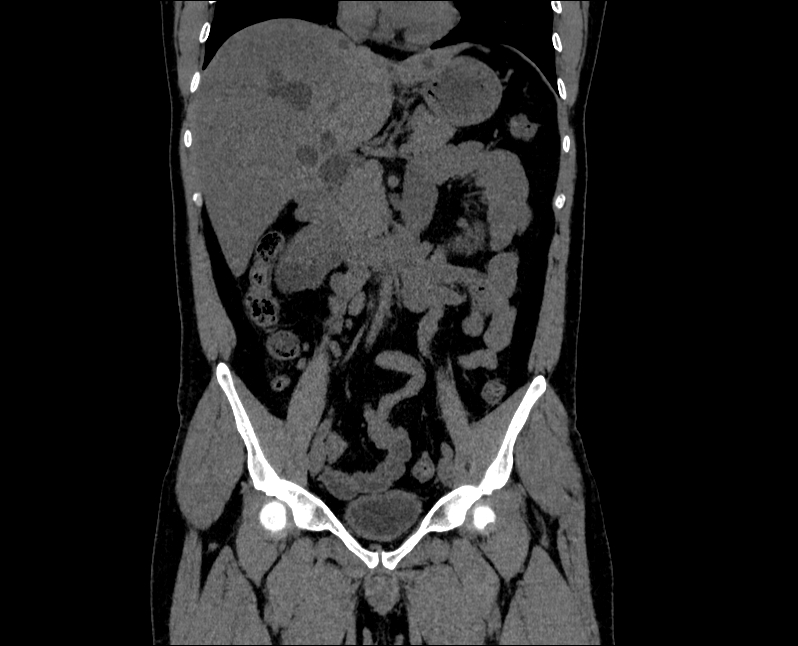

In [16]:
image = ex['image']
image

In [17]:
labels = dataset['train'].features['labels']
labels

ClassLabel(names=['Cyst', 'Normal', 'Stone', 'Tumor'], id=None)

In [18]:
labels.int2str(ex['labels'])

'Cyst'

Filter:   0%|          | 0/12446 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12446 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12446 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12446 [00:00<?, ? examples/s]

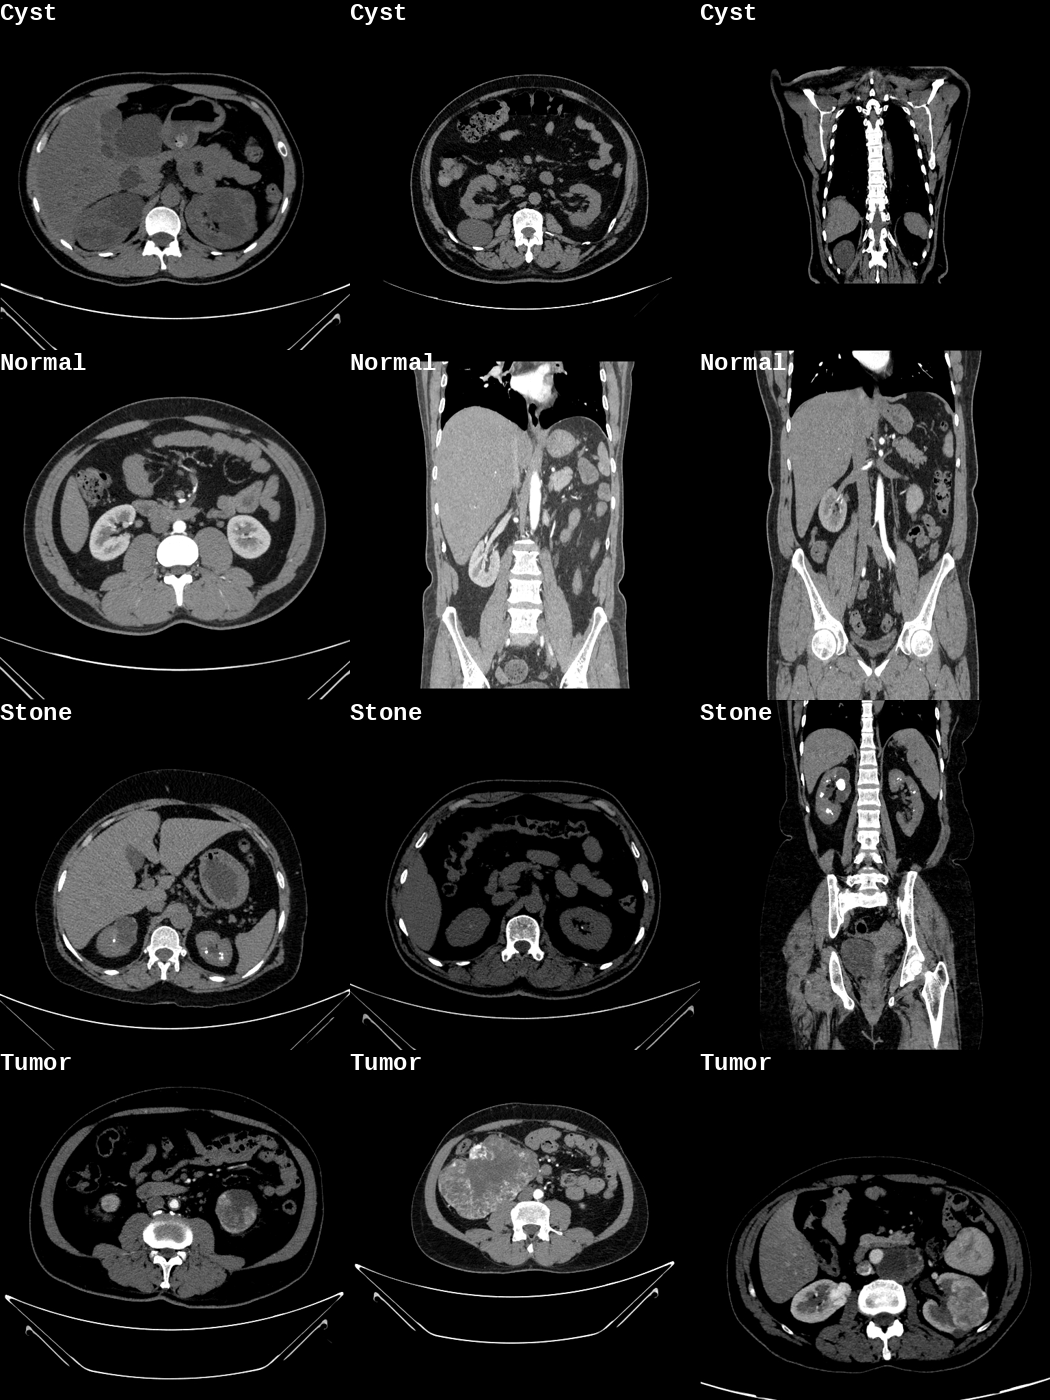

In [19]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['labels'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['labels'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(dataset, seed=random.randint(0, 1337), examples_per_class=3)

In [52]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

In [21]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [22]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])}

In [23]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [24]:
process_example(dataset['train'][0])

{'pixel_values': tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]]), 'labels': 0}

In [25]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

prepared_ds = dataset.with_transform(transform)

In [26]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1

### Define our data collator

Batches are coming in as lists of dicts, so we just unpack + stack those into batch tensors.

We return a batch `dict` from our `collate_fn` so we can simply `**unpack` the inputs to our model later. ✨

In [27]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

### Define an evaluation metric

Here, we load the [accuracy](https://huggingface.co/metrics/accuracy) metric from `datasets`, and then write a function that takes in a model prediction + computes the accuracy.

In [28]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-28-3044fb6e3895>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Now we can load our pretrained model. We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels in the 🤗 hub widget if we choose to `push_to_hub`.

In [115]:
from transformers import ViTForImageClassification

labels = dataset['train'].features['labels'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We're almost ready to train! The last thing we'll do before that is set up the training configuration by defining [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments).

Most of these are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually its ideal to drop unused feature columns, as it makes it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set `remove_unused_columns=False`.

In [116]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-base-kidney-ct-V1",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=2,
  fp16=False,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [60]:
!pip show accelerate

Name: accelerate
Version: 0.24.1
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, torch
Required-by: 


Now, all instances can be passed to Trainer and we are ready to start training!



In [117]:
prepared_ds = prepared_ds['train'].train_test_split(test_size=0.25)

In [118]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=feature_extractor,
)

In [119]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,0.331900,0.240340,0.936024
200,0.032400,0.073987,0.985529
300,0.046700,0.073575,0.977913
400,0.012900,0.056366,0.987053


***** train metrics *****
  epoch                    =         2.0
  total_flos               = 568277075GF
  train_loss               =      0.1838
  train_runtime            =  0:08:53.00
  train_samples_per_second =      14.773
  train_steps_per_second   =       0.927


In [120]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        2.0
  eval_accuracy           =     0.9871
  eval_loss               =     0.0564
  eval_runtime            = 0:00:31.69
  eval_samples_per_second =     41.425
  eval_steps_per_second   =      5.206


In [ ]:
!zip -r '/content/vit-base-kidney-ct-V1.zip' '/content/vit-base-kidney-ct-V1/'

  adding: content/vit-base-kidney-ct-V1/ (stored 0%)
  adding: content/vit-base-kidney-ct-V1/all_results.json (deflated 53%)
  adding: content/vit-base-kidney-ct-V1/trainer_state.json (deflated 85%)
  adding: content/vit-base-kidney-ct-V1/checkpoint-1000/ (stored 0%)
  adding: content/vit-base-kidney-ct-V1/checkpoint-1000/trainer_state.json (deflated 84%)
  adding: content/vit-base-kidney-ct-V1/checkpoint-1000/rng_state.pth (deflated 25%)
  adding: content/vit-base-kidney-ct-V1/checkpoint-1000/pytorch_model.bin (deflated 7%)
  adding: content/vit-base-kidney-ct-V1/checkpoint-1000/config.json (deflated 49%)
  adding: content/vit-base-kidney-ct-V1/checkpoint-1000/training_args.bin (deflated 51%)
  adding: content/vit-base-kidney-ct-V1/checkpoint-1000/preprocessor_config.json (deflated 46%)
  adding: content/vit-base-kidney-ct-V1/checkpoint-1000/optimizer.pt (deflated 8%)
  adding: content/vit-base-kidney-ct-V1/checkpoint-1000/scheduler.pt (deflated 55%)
  adding: content/vit-base-kidney-

In [121]:
import torch
import torchvision
import  torchvision.transforms as transforms

In [122]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
#inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

In [123]:
def saliency(img, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False

    #set model in eval mode
    model.eval()
    #transoform input PIL image to torch.Tensor and normalize
    input = transform(img)
    input = input.cuda()
    input.unsqueeze_(0)

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input
    input.requires_grad = True
    #forward pass to calculate predictions
    preds = model(input)
    score, indices = torch.max(preds.logits, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())

    #apply inverse transform on image
    with torch.no_grad():
        input_img = inv_normalize(input[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(torch.Tensor.cpu(input_img).detach().numpy(), (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(torch.Tensor.cpu(slc).numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [124]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [125]:
from PIL import Image
import matplotlib.pyplot as plt

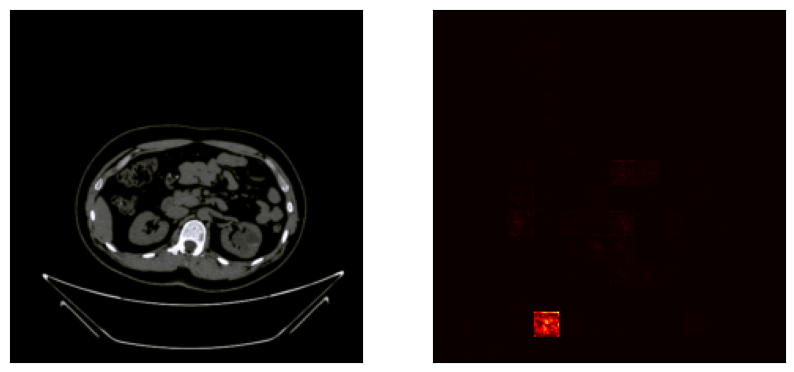

In [126]:
img = Image.open('./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (1006).jpg').convert('RGB')
saliency(img, model)

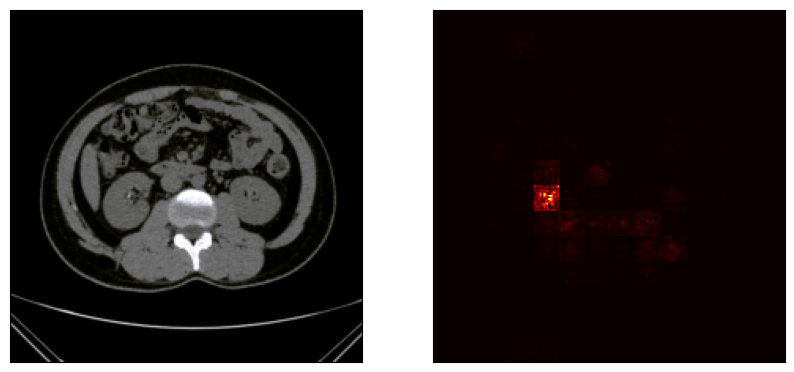

In [127]:
img = Image.open('./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (1003).jpg').convert('RGB')
saliency(img, model)

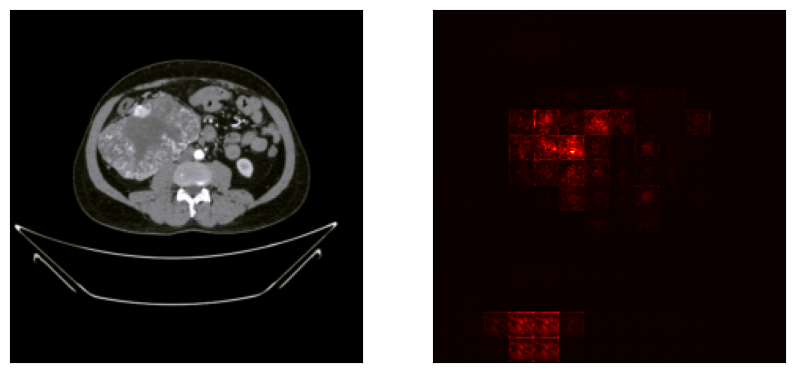

In [128]:
img = Image.open('./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (100).jpg').convert('RGB')
saliency(img, model)

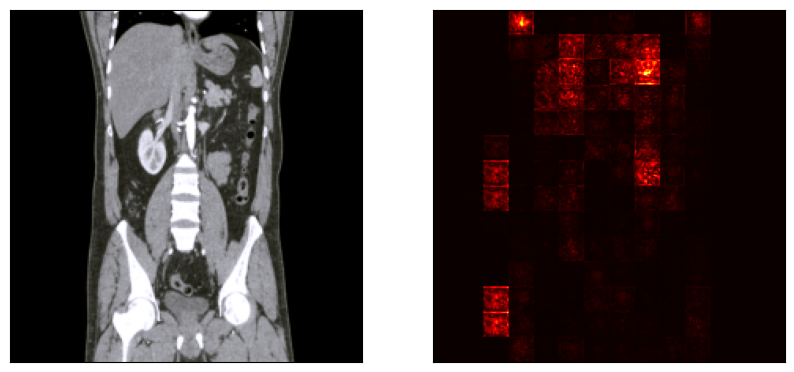

In [129]:
img = Image.open('./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (1004).jpg').convert('RGB')
saliency(img, model)

Step by step breakdown

In [130]:
#we don't need gradients w.r.t. weights for a trained model
for param in model.parameters():
    param.requires_grad = False

#set model in eval mode
model.eval()
#transoform input PIL image to torch.Tensor and normalize
input = transform(img)
input = input.cuda()
input.unsqueeze_(0)

tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [131]:
input.requires_grad = True
#forward pass to calculate predictions


In [132]:
preds = model(input)

In [133]:
preds

ImageClassifierOutput(loss=None, logits=tensor([[-1.7102,  3.8382, -1.8453, -0.4671]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [134]:
score, indices = torch.max(preds.logits, 1)

In [135]:
score, indices

(tensor([3.8382], device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([1], device='cuda:0'))

In [136]:
#backward pass to get gradients of score predicted class w.r.t. input image
score.backward()

In [137]:
input.grad

tensor([[[[ 2.8062e-05,  5.5409e-06, -1.6676e-05,  ...,  6.7382e-05,
            7.1960e-05,  1.4988e-04],
          [ 1.9512e-05,  1.6030e-05, -2.9781e-05,  ..., -2.5098e-05,
           -3.3705e-05,  7.0830e-05],
          [ 3.9494e-05,  3.3722e-05,  3.2958e-06,  ..., -8.8328e-06,
           -2.7816e-06,  8.4221e-05],
          ...,
          [-6.4546e-06, -3.2531e-05, -4.2249e-05,  ..., -5.2538e-07,
           -3.5337e-05,  9.8383e-07],
          [-1.0680e-05, -2.4410e-05, -1.7636e-05,  ..., -2.9767e-05,
           -3.3451e-05,  2.6565e-05],
          [ 3.8541e-05,  5.5465e-06, -7.9894e-06,  ...,  2.0212e-05,
            2.1772e-05,  7.6140e-05]],

         [[ 3.4865e-05,  2.5769e-05,  3.4248e-05,  ...,  1.2070e-04,
            1.3008e-04,  2.0153e-04],
          [ 2.5107e-05, -2.1201e-06, -2.5926e-05,  ...,  3.5383e-06,
            7.2629e-06,  9.2991e-05],
          [ 2.2053e-05,  1.2765e-05, -3.0346e-06,  ...,  2.6574e-06,
            5.2704e-06,  7.7863e-05],
          ...,
     

In [138]:
#get max along channel axis
slc, _ = torch.max(torch.abs(input.grad[0]), dim=0)

In [139]:
slc

tensor([[3.5706e-05, 2.5769e-05, 3.4248e-05,  ..., 1.2070e-04, 1.3008e-04,
         2.0153e-04],
        [2.5107e-05, 3.1202e-05, 2.9957e-05,  ..., 5.0727e-05, 6.1462e-05,
         9.2991e-05],
        [3.9494e-05, 3.3722e-05, 3.2958e-06,  ..., 3.6845e-05, 4.0456e-05,
         8.4221e-05],
        ...,
        [2.0053e-05, 3.2531e-05, 4.2249e-05,  ..., 2.0697e-06, 3.5337e-05,
         1.4574e-05],
        [1.3491e-05, 3.2139e-05, 1.7636e-05,  ..., 2.9767e-05, 3.3451e-05,
         4.0541e-05],
        [5.1910e-05, 2.9155e-05, 1.1321e-05,  ..., 7.1991e-05, 7.0569e-05,
         9.1057e-05]], device='cuda:0')

In [140]:
#normalize to [0..1]
slc = (slc - slc.min())/(slc.max()-slc.min())

In [141]:
#apply inverse transform on image
with torch.no_grad():
    input_img = inv_normalize(input[0])

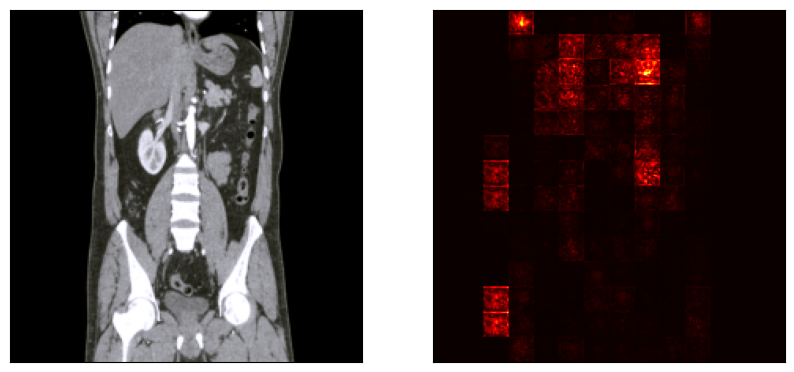

In [142]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(torch.Tensor.cpu(input_img).detach().numpy(), (1, 2, 0)))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(torch.Tensor.cpu(slc).numpy(), cmap=plt.cm.hot)
plt.xticks([])
plt.yticks([])
plt.show()